# Prophage Comparison Analysis

This jupyter notebook parses the output from [scripts/parse_prophage_predictions.pl](https://github.com/linsalrob/ProphagePredictionComparisons/blob/master/scripts/parse_prophage_predictions.pl) that makes a table with the following columns:

 - prophage caller (e.g. phispy, phage_finder, etc)
 - bacterial genome name
 - true positives (TP)
 - true negatives (TN)
 - false positives (FP)
 - false negatives (FN)
 - accuracy : the ratio of the correctly labeled phage genes to the whole pool of genes
 - precision : the ratio of correctly labeled phage genes to all predictions
 - recall : the fraction of actual phage genes we got right
 - specficity : the fraction of non phage genes we got right
 - F1 score : the harmonic mean of precision and recall, and is the best measure when, as in this case, there is a big difference between the number of phage and non-phage genes



In [106]:
import os, sys
import itertools
import re
import json
%matplotlib inline
from random import randint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
from math import log, e
from scipy import stats
from math import sqrt

## Read the results

This is the raw data. Note that `tsv` file has a header row.

In [107]:
df = pd.read_csv('all_tptn.tsv', delimiter="\t")
df.head()

,Prophage Caller,Genome,TP,TN,FP,FN,Accuracy,Precision,Recall,Specificity,f1 score
0,phage_finder,Achromobacter_denitrificans_strain_PR1,56,6398,4,73,0.988,0.933,0.434,0.999,0.593
1,phage_finder,Bacillus_halodurans_C-125,46,4186,0,0,1.000,1.000,1.000,1.000,1.000
2,phage_finder,Bacillus_subtilis_subsp._subtilis_str._168,39,4203,7,244,0.944,0.848,0.138,0.998,0.237
3,phage_finder,Bacteroides_uniformis_ATCC_8492_strain_81A2,23,4248,0,334,0.927,1.000,0.064,1.000,0.121
4,phage_finder,Bifidobacterium_longum_NCC2705,27,1824,0,51,0.973,1.000,0.346,1.000,0.514


## Plot the accuracy, precision, sensitivity, and specificity

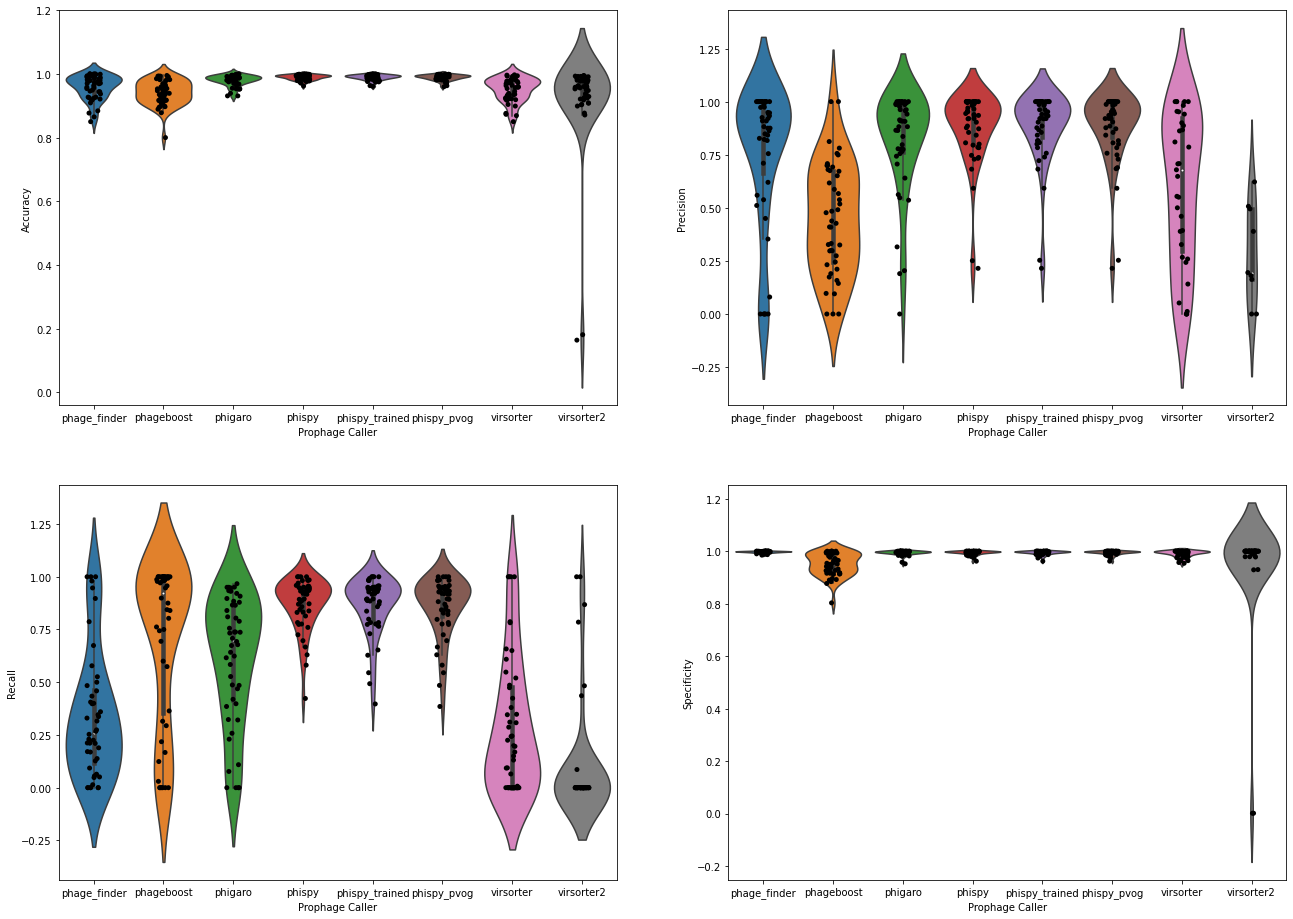

In [108]:
fig, ax = plt.subplots(2,2, figsize=(22,16))

ax_x = 0
for i, j in enumerate(df.columns[6:10]):
    if i > 1:
        ax_x = 1
        ax_y = i-2
    else:
        ax_y = i
    sns.violinplot(ax = ax[ax_x, ax_y], x="Prophage Caller", y=j, data=df, scale="count" )
    sns.stripplot(ax = ax[ax_x, ax_y], x="Prophage Caller", y=j, data=df, jitter=True, color="Black")
    #ax[ax_x, ax_y].set(ylim=(-0.39,1.39))
#fig.savefig("sensitivity_specificity.png")
fig.savefig("sensitivity_specificity_rel.png")

## F<sub>1</sub> Score

This is the most robust score since we have a lot of non-phage genes, and a relatively few phage genes.

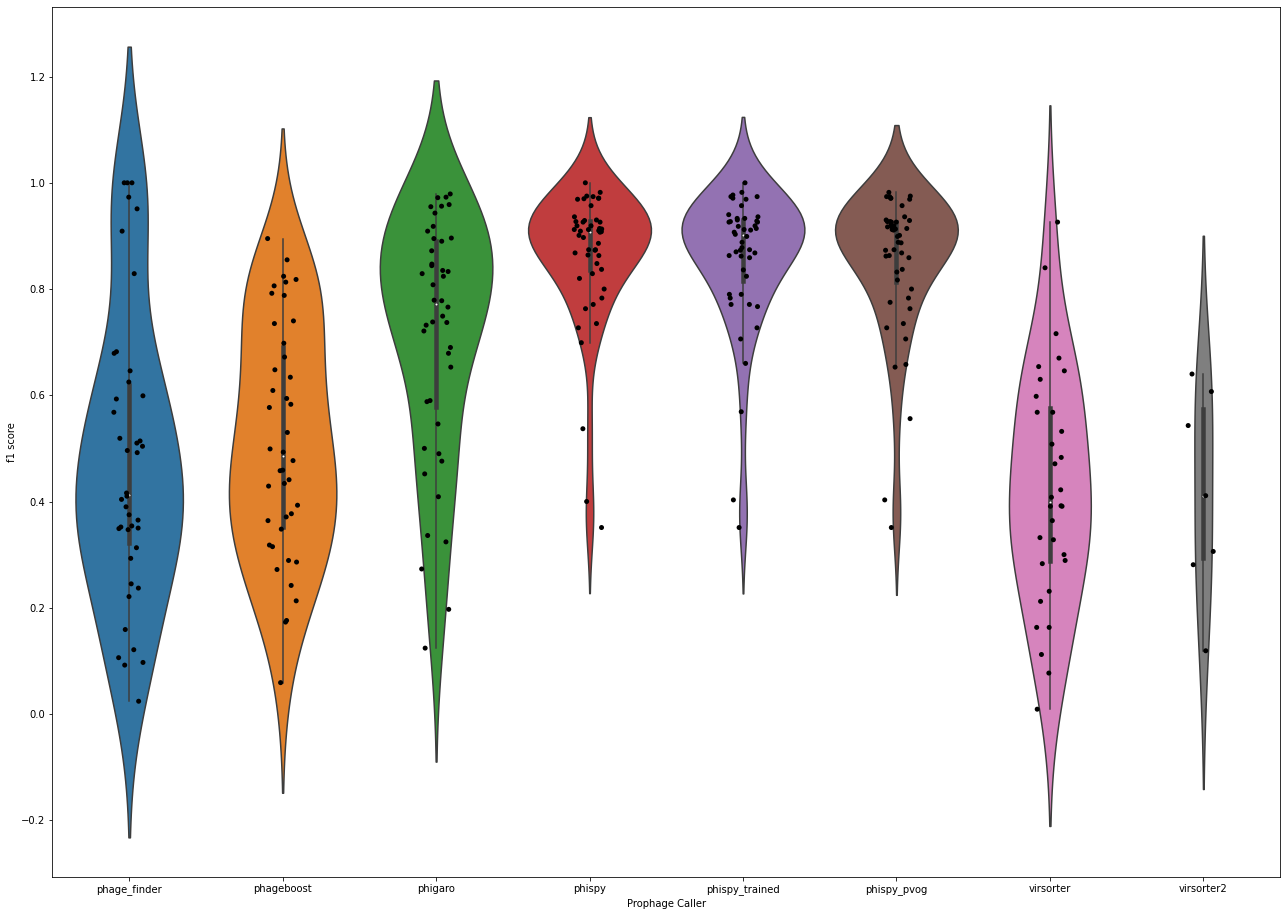

In [109]:
fig, ax = plt.subplots(figsize=(22,16))

sns.violinplot(ax = ax, x="Prophage Caller", y="f1 score", data=df, scale="count" )
sns.stripplot(ax = ax, x="Prophage Caller", y="f1 score", data=df, jitter=True, color="Black")
fig.savefig("f1_score.png")

### Show me all the data

Here is all the data!

In [110]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,Prophage Caller,Genome,TP,TN,FP,FN,Accuracy,Precision,Recall,Specificity,f1 score
0,phage_finder,Achromobacter_denitrificans_strain_PR1,56,6398,4,73,0.988,0.933,0.434,0.999,0.593
1,phage_finder,Bacillus_halodurans_C-125,46,4186,0,0,1.000,1.000,1.000,1.000,1.000
2,phage_finder,Bacillus_subtilis_subsp._subtilis_str._168,39,4203,7,244,0.944,0.848,0.138,0.998,0.237
3,phage_finder,Bacteroides_uniformis_ATCC_8492_strain_81A2,23,4248,0,334,0.927,1.000,0.064,1.000,0.121
4,phage_finder,Bifidobacterium_longum_NCC2705,27,1824,0,51,0.973,1.000,0.346,1.000,0.514
5,phage_finder,Brucella_melitensis_16M,0,3265,12,78,0.973,0.000,0.000,0.996,NaN
6,phage_finder,Caulobacter_crescentus_CB15,18,3739,0,1,1.000,1.000,0.947,1.000,0.973
7,phage_finder,Clostridium_perfringens_str._13,0,2712,16,43,0.979,0.000,0.000,0.994,NaN
8,phage_finder,Clostridium_tetani_E88,66,2544,27,100,0.954,0.710,0.398,0.989,0.510
9,phage_finder,Deinococcus_radiodurans_R1,0,3222,49,31,0.976,0.000,0.000,0.985,NaN


### Do all the callers identify prophages in all the genomes

Not quite. We have manually curated prophages in each of these genomes, but some of the callers fall short. This is a simple way to count those

In [111]:
df[np.isnan(df['f1 score'])].groupby('Prophage Caller').count()

,Genome,TP,TN,FP,FN,Accuracy,Precision,Recall,Specificity,f1 score
Prophage Caller,,,,,,,,,,
phage_finder,6,6,6,6,6,6,5,6,6,0
phageboost,6,6,6,6,6,6,3,6,6,0
phigaro,4,4,4,4,4,4,1,4,4,0
virsorter,16,16,16,16,16,16,3,16,16,0
virsorter2,41,41,41,41,41,41,2,41,41,0


# Speed and Memory Consumption

The accuracy is one part of the story. We also need to worry about speed and memory consumption. We leverage the benchmarking included in `snakemake` to record that data. The script [parse_benchmarks](https://github.com/linsalrob/ProphagePredictionComparisons/blob/master/scripts/parse_benchmarks.pl) will convert that data into a `tsv` file that we read here.

In [112]:
bf = pd.read_csv("all_benchmarks.tsv", delimiter="\t")
bf.head()

,Prophage_caller,Genome,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
0,phage_finder,Achromobacter_denitrificans_strain_PR1,215.0689,0:03:35,18.90,198.25,11.26,11.49,0.0,0.91,167.82,361.64
1,phage_finder,Bacillus_halodurans_C-125,159.7786,0:02:39,1009.08,1791.41,995.70,996.85,0.0,5.29,133.36,6.48
2,phage_finder,Bacillus_subtilis_subsp._subtilis_str._168,171.4187,0:02:51,48.63,198.44,41.46,41.94,0.0,5.34,125.24,1.25
3,phage_finder,Bacteroides_uniformis_ATCC_8492_strain_81A2,273.1262,0:04:33,387.45,562.36,374.13,375.08,0.0,11.11,121.16,1.06
4,phage_finder,Bifidobacterium_longum_NCC2705,97.2178,0:01:37,419.80,1020.04,405.95,406.84,0.0,3.30,98.06,1.55


## Who is the fastest?

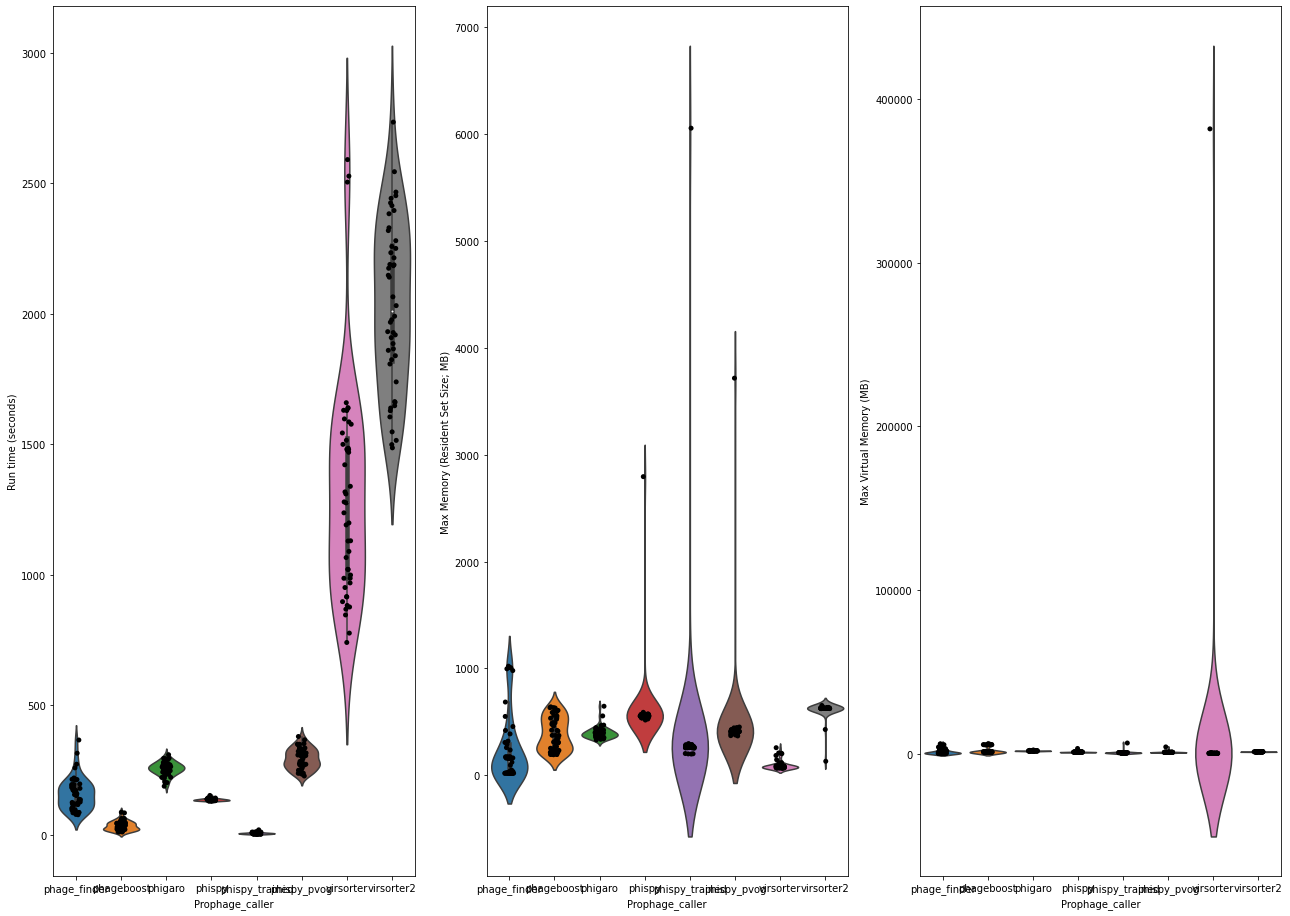

In [113]:
# here we plot all three data sets, but we really only want time and Virtual memory.
fig, ax = plt.subplots(1,3, figsize=(22,16))

labels = ["Run time (seconds)", "Max Memory (Resident Set Size; MB)", "Max Virtual Memory (MB)"]

for i, j in enumerate([bf.columns[i] for i in [2,4,5]]):
    sns.violinplot(ax = ax[i], x="Prophage_caller", y=j, data=bf, scale="count")
    sns.stripplot(ax = ax[i], x="Prophage_caller", y=j, data=bf, jitter=True, color="Black")
    ax[i].set(ylabel=labels[i])


fig.savefig("timing.png")

plt.show(fig)


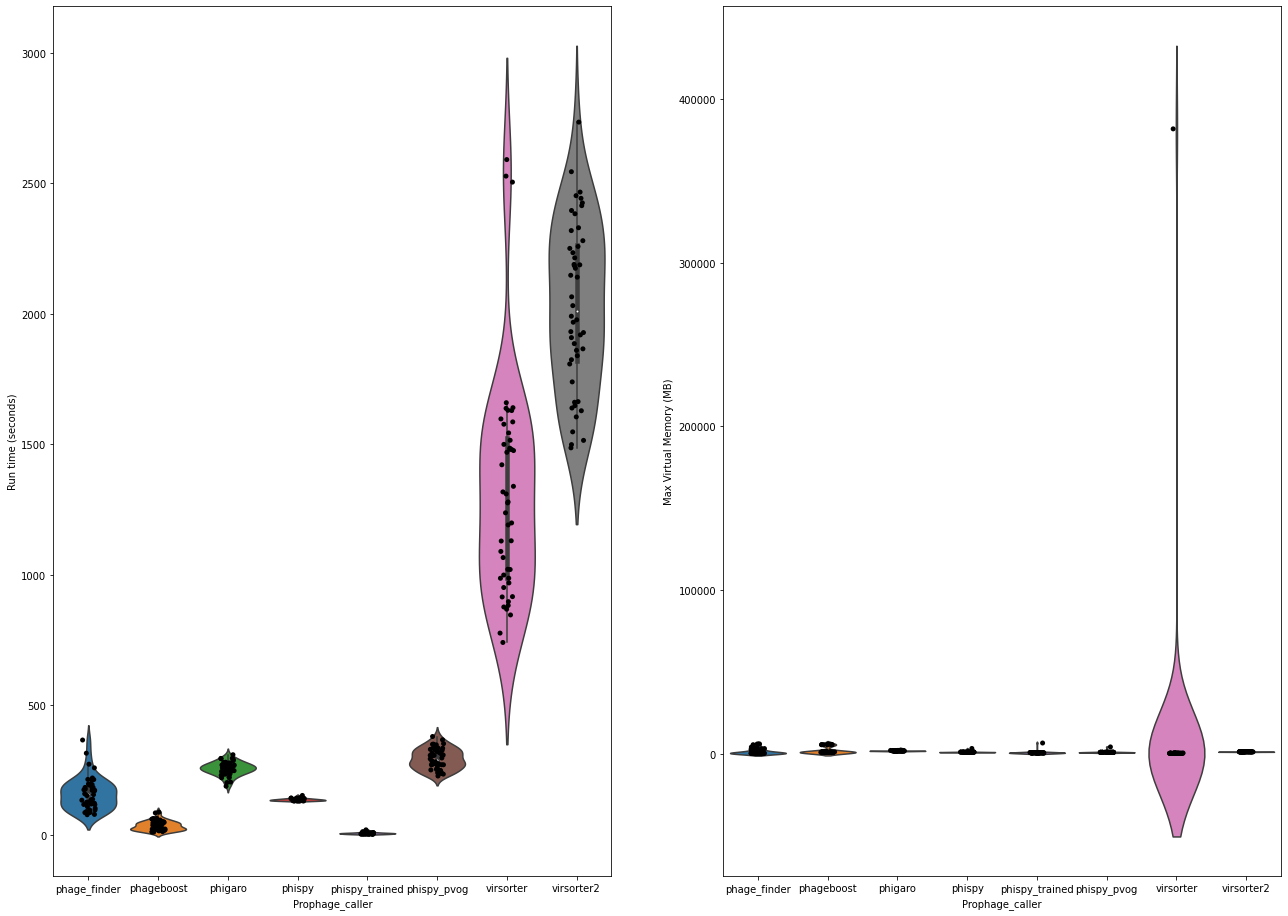

In [114]:
# here we plot time and Virtual memory.
fig, ax = plt.subplots(1,2, figsize=(22,16))

labels = ["Run time (seconds)", "Max Virtual Memory (MB)"]

for i, j in enumerate([bf.columns[i] for i in [2,5]]):
    sns.violinplot(ax = ax[i], x="Prophage_caller", y=j, data=bf, scale="count")
    sns.stripplot(ax = ax[i], x="Prophage_caller", y=j, data=bf, jitter=True, color="Black")
    ax[i].set(ylabel=labels[i])


fig.savefig("timing.png")

plt.show(fig)


In [115]:
sdf = df.groupby('Prophage Caller').describe().transpose()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(sdf)

Prophage Caller    phage_finder   phageboost      phigaro       phispy  \
TP          count     48.000000    48.000000    48.000000    48.000000   
            mean      36.666667   131.895833   119.187500   152.854167   
            std       22.852285   150.818087   134.812503   140.795912   
            min        0.000000     0.000000     0.000000    16.000000   
            25%       17.750000    33.750000    30.750000    47.500000   
            50%       37.000000    80.500000    74.500000   125.000000   
            75%       58.250000   180.250000   163.750000   216.500000   
            max       72.000000   706.000000   643.000000   680.000000   
TN          count     48.000000    48.000000    48.000000    48.000000   
            mean    3627.937500  3463.395833  3614.687500  3616.583333   
            std     1345.777722  1323.626815  1336.501501  1335.433165   
            min     1589.000000  1472.000000  1587.000000  1588.000000   
            25%     2542.750000  2383.000000  2556.500000  2559.000000   
            50%     3481.000000  3326.500000  3487.000000  3483.500000   
            75%     4439.000000  4218.500000  4400.250000  4392.250000   
            max     7663.000000  7651.000000  7641.000000  7644.000000   
FP          count     48.000000    48.000000    48.000000    48.000000   
            mean       9.437500   173.979167    22.687500    20.791667   
            std       12.887246   176.537681    40.277313    35.545571   
            min        0.000000     0.000000     0.000000     0.000000   
            25%        0.000000    22.500000     1.000000     0.000000   
            50%        4.000000   139.500000     8.000000     7.500000   
            75%       12.250000   291.750000    26.500000    22.500000   
            max       55.000000   837.000000   222.000000   176.000000   
FN          count     48.000000    48.000000    48.000000    48.000000   
            mean     136.270833    41.041667    53.750000    20.083333   
            std      147.025651    69.888348    60.100802    21.558267   
            min        0.000000     0.000000     1.000000     0.000000   
            25%       32.500000     0.750000    16.750000     4.750000   
            50%       89.500000     9.000000    34.500000    13.000000   
            75%      214.750000    47.500000    69.750000    28.500000   
            max      690.000000   320.000000   318.000000   100.000000   
Accuracy    count     48.000000    48.000000    48.000000    48.000000   
            mean       0.958625     0.942083     0.979917     0.989583   
            std        0.038224     0.039073     0.017358     0.008440   
            min        0.850000     0.800000     0.931000     0.962000   
            25%        0.934500     0.917000     0.974750     0.983750   
            50%        0.972000     0.944500     0.986000     0.992500   
            75%        0.988750     0.971250     0.992000     0.996000   
            max        1.000000     0.995000     1.000000     1.000000   
Precision   count     47.000000    45.000000    45.000000    48.000000   
            mean       0.757298     0.449689     0.817489     0.879167   
            std        0.329208     0.262166     0.242772     0.171155   
            min        0.000000     0.000000     0.000000     0.215000   
            25%        0.665000     0.245000     0.765000     0.804500   
            50%        0.909000     0.438000     0.908000     0.937000   
            75%        1.000000     0.675000     0.992000     1.000000   
            max        1.000000     1.000000     1.000000     1.000000   
Recall      count     48.000000    48.000000    48.000000    48.000000   
            mean       0.341354     0.701437     0.614625     0.875188   
            std        0.303828     0.381727     0.301193     0.121418   
            min        0.000000     0.000000     0.000000     0.423000   
            25%        0.118500     0.351750     0.413750     0.832500   
    

In [116]:
tdf = bf.groupby('Prophage_caller').describe().transpose()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(tdf)

Prophage_caller  phage_finder   phageboost      phigaro       phispy  \
s         count     48.000000    48.000000    48.000000    48.000000   
          mean     161.022760    37.751846   256.492715   137.269635   
          std       61.449162    18.284638    25.301992     4.051487   
          min       79.418200    12.997800   188.726100   131.993600   
          25%      118.620900    23.946650   244.454075   133.848800   
          50%      158.171750    35.539850   259.149450   136.694600   
          75%      193.825225    49.050975   274.126975   139.622175   
          max      365.765300    89.082700   309.410600   153.304000   
max_rss   count     48.000000    48.000000    48.000000    48.000000   
          mean     232.524375   388.661667   398.461875   601.477500   
          std      306.985695   152.649965    55.555342   323.644137   
          min       18.900000   192.500000   330.920000   517.240000   
          25%       20.417500   246.037500   362.177500   546.282500   
          50%      137.885000   372.670000   388.310000   555.265000   
          75%      294.690000   526.827500   424.085000   566.515000   
          max     1021.070000   640.610000   646.340000  2794.990000   
max_vms   count     48.000000    48.000000    48.000000    48.000000   
          mean    1283.683750  1970.085208  1694.820625   952.673125   
          std     1609.327864  1976.092044   148.294727   323.800708   
          min      198.120000   720.990000  1457.260000   840.710000   
          25%      198.397500   779.822500  1594.872500   888.345000   
          50%      375.650000   965.245000  1691.575000   912.145000   
          75%     1708.250000  1226.382500  1753.340000   926.167500   
          max     5909.580000  5774.880000  2214.310000  3141.400000   
max_uss   count     48.000000    48.000000    48.000000    48.000000   
          mean     221.118125   317.777083   365.877917   567.493333   
          std      305.937233   148.987313    55.399621   328.279823   
          min        5.490000   124.440000   297.780000   482.550000   
          25%        9.317500   177.235000   331.875000   511.705000   
          50%      128.095000   298.985000   355.875000   520.810000   
          75%      284.377500   457.795000   389.587500   531.517500   
          max     1007.530000   572.890000   614.000000  2792.520000   
max_pss   count     48.000000    48.000000    48.000000    48.000000   
          mean     221.834583   321.519583   367.467292   568.872708   
          std      306.030192   149.014442    55.608856   328.120185   
          min        6.180000   127.560000   298.610000   483.110000   
          25%       10.160000   178.770000   333.030000   512.290000   
          50%      128.620000   303.285000   357.780000   521.415000   
          75%      285.337500   460.645000   391.022500   532.400000   
          max     1008.320000   577.690000   615.300000  2792.560000   
io_in     count     48.000000    48.000000    48.000000    48.000000   
          mean       0.000000     0.000000     0.000000     0.000000   
          std        0.000000     0.000000     0.000000     0.000000   
          min        0.000000     0.000000     0.000000     0.000000   
          25%        0.000000     0.000000     0.000000     0.000000   
          50%        0.000000     0.000000     0.000000     0.000000   
          75%        0.000000     0.000000     0.000000     0.000000   
          max        0.000000     0.000000     0.000000     0.000000   
io_out    count     48.000000    48.000000    48.000000    48.000000   
          mean       5.901667     0.000208     6.177292     3.233333   
          std        6.422594     0.001443     2.205541     5.446114   
          min        0.730000     0.000000     3.000000     0.000000   
          25%        1.285000     0.000000     4.550000     0.000000   
          50%        5.260000     0.000000     5.940000     0.000000   
          75%        7.060000     0.0000